# Machine Learning Semester Project
## Murtaza Hussain (29449) and Muhammad Asad ur Rehman (29456)

### Class Imbalance Problem

The below code solves the prevalent problem of imbalanced dataset, where one class dominates the dataset as compared to the other. Such is the case for the following dataset for Credit Card Transactions to detect Fraudulent Transactions. We will evaluate the following methods to resolve Class Imbalance:
1. Random Under Sampling
2. Algorithmic Methods (Using Random Forest as well as modifying Class Weights)
3. Anomaly Detection Method

For the following Dataset, we will use the following 5 Algorithms to draw a comparision between different methods:
1. Logistic Regression
2. K-Nearest Neighbors (KNN)
3. Random Forest
4. Support Vector Machines (SVM)
5. Naive Bayes (Gaussian)

In [1]:
# Import necessary libraries
from sklearn.metrics import precision_recall_curve, make_scorer, recall_score, precision_score
from sklearn.model_selection import train_test_split, cross_validate, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, IsolationForest
from sklearn.neighbors import KNeighborsClassifier, LocalOutlierFactor
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC, OneClassSVM
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

pd.options.display.float_format = '{:,.4f}'.format

In [2]:
# Data Loader loads data from CSV Files
def load_dataset():
    dataset = pd.read_csv("./Source.StrokeData.csv")
    return dataset

df = load_dataset()

In [3]:
# This function performs a missing value analysis on each column of the dataset, helps you decide on what to do in cleaning process
def null_check(df):
    null_columns = []
    for column in df.columns:
        print("Column Name:", column)
        print("Column DataType:", df[column].dtype)
        if df[column].dtype != 'float64' and df[column].dtype != 'int64':
            print("Column unique values:", df[column].unique())
        print("Column has null:", df[column].isnull().any())

        
        if df[column].isnull().any() == True:
            print("Column Null Count:", df[column].isnull().sum())
            null_columns.append(column)
        print("\n")
    return null_columns

# null_check(df)

In [4]:
# This function drops any null columns and missing values
# This is where you decide whether to remove NULL rows (which will reduce the size of Dataset) or remove NULL columns entirely. You can also choose a combination of both.
def clean_data(df, drop_columns, missing_value = False):
    # Remove unnecessary columns
    df.drop(drop_columns, axis=1, inplace=True)
    # Drop rows with any missing values
    if missing_value == False:
        df.dropna(inplace=True)
    else:
        df.fillna(missing_value, inplace=True)
    return df

In [5]:
# Prints a summary of class instances and distribution
def data_summary(df, target=None):
    if isinstance(df, pd.DataFrame) and target!=None:
        a = df[target].value_counts()
    else:
        a = df.value_counts()
    class0 = format(100 * a[0]/sum(a), ".2f")
    class1 = format(100 * a[1]/sum(a), ".2f")

    meta = pd.DataFrame([{ "%": class0, "count": a[0]},
                         { "%": class1, "count": a[1]}])
    print("\nClass Distribution:\n", meta, "\n")

data_summary(df,'stroke')


Class Distribution:
        %  count
0  89.07   5240
1  10.93    643 



In [6]:
# Transforms categorical and numberical data into numerical data
def transform_data(df):
    # Encode categorical variables
    label_encoder = LabelEncoder()
    print("Categorical columns:", df.select_dtypes(include=['object', 'int64']).columns)
    for col in df.select_dtypes(include=['object']).columns:
        df[col] = label_encoder.fit_transform(df[col])
    
    # Standardize numerical features
    scaler = StandardScaler()
    print("Numerical columns:", df.select_dtypes(include=['float64']).columns)
    numerical_cols = df.select_dtypes(include=['float64', 'int64']).columns
    if len(numerical_cols) > 0:
        df[numerical_cols] = scaler.fit_transform(df[numerical_cols])
    return df

df['stroke'] = df['stroke'].astype(str)
df = transform_data(df)

Categorical columns: Index(['id', 'gender', 'hypertension', 'heart_disease', 'ever_married',
       'work_type', 'Residence_type', 'smoking_status', 'stroke'],
      dtype='object')
Numerical columns: Index(['age', 'avg_glucose_level', 'bmi'], dtype='object')


In [7]:
# Runs Baseline Model for All 5 Algorithms
def BaselineRunAll(df, target_name, k=10):

    # Separate features and targets
    X = df.drop(target_name, axis=1)
    y = df[target_name]
    results = []

    print("Class Distribution for Baseline Run:")
    data_summary(y)

    # Initialize the classifiers
    lr_classifier = LogisticRegression(max_iter=1000)
    rf_classifier = RandomForestClassifier()
    knn_classifier = KNeighborsClassifier()
    svm_classifier = SVC()
    nb_classifier = GaussianNB()
    

    # Initialize k-fold cross-validation where folds = 10
    k_fold = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)     # The reasoning behind k = 10 is so as to strike a balance between test and train samples of minority class

    # Define a recall and precision scorer specifically focusing on the minority class
    recall_precision_scorer = {'recall': make_scorer(recall_score, pos_label=1), # As the majority class has 99.81% presence, accuracy cannot be used as a metric to evaluate performance
                               'precision': make_scorer(precision_score, pos_label=1)}
    
    classifiers = {
        'Logistic Regression': lr_classifier,
        'Random Forest': rf_classifier,
        'K-Nearest Neighbours': knn_classifier,
        'Support Vector Machines': svm_classifier,
        'Naive Bayes': nb_classifier
    }

    for clf_name, clf in classifiers.items():
        scores = cross_validate(clf, X, y, cv=k_fold, scoring=recall_precision_scorer)
        print(f"{clf_name} Model Training Completed")
        mean_recall = scores['test_recall'].mean()
        mean_precision = scores['test_precision'].mean()

        results.append({
            'Method': 'Baseline',
            'Classifier': clf_name,
            'Class 1 Recall': mean_recall,
            'Class 1 Precision': mean_precision
        })

    df = pd.DataFrame(results)
    return df

# results = BaselineRunAll(df, 'stroke')
# print(results)

In [8]:
# Performs One Class Learning (Majority Class) on all 5 Algorithms
def OneClassLearningAdjustedAlgorithms(df, target_name):

    # Separate features and targets
    X = df.drop(target_name, axis=1)
    y = df[target_name]
    results = []

    print("Class Distribution for One Class Learning (Adjusted Algorithms):")
    data_summary(y)

    # Splitting Data into Majority and Minority Classes
    X_majority = X[y == 0]  # Features for the majority class
    X_minority = X[y == 1]  # Features for the minority class

    X_train_minority, X_test_minority = train_test_split(X_minority, test_size=0.9, random_state=42)
    X_train_majority, X_test_majority = train_test_split(X_majority, test_size=0.2, random_state=42)

    # Adjusting test and train samples
    X_train = np.vstack([X_train_majority, X_train_minority])  # Training Majority Class with some samples for Minority Class (Else most Classifiers give an error as they are built to handle atleast 2 classes)
    X_test = np.vstack([X_test_majority, X_test_minority])
    y_train = np.array([0]*len(X_train_majority) + [1]*len(X_train_minority))
    y_test = np.array([0]*len(X_test_majority) + [1]*len(X_test_minority))

    # Initialize the classifiers
    lr_classifier = LogisticRegression(max_iter=1000)
    rf_classifier = RandomForestClassifier()
    knn_classifier = KNeighborsClassifier()
    svm_classifier = SVC(probability=True)
    nb_classifier = GaussianNB()

    classifiers = {
        'Logistic Regression': lr_classifier,
        'Random Forest': rf_classifier,
        'K-Nearest Neighbours': knn_classifier,
        'Support Vector Machines': svm_classifier,
        'Naive Bayes': nb_classifier
    }

    for clf_name, clf in classifiers.items():
        # Train the model
        clf.fit(X_train, y_train)
        print(f"{clf_name} Model Training Completed")
        # Evaluate the model
        predictions = clf.predict(X_test)
        # Convert probabilities to binary output based on a chosen threshold
        probabilities = clf.predict_proba(X_test)[:, 1]

        # Calculate the optimal threshold for maximum precision-recall
        precisions, recalls, thresholds = precision_recall_curve(y_test, probabilities)
        # Calculate F1 scores for each threshold
        f1_scores = 2 * (precisions * recalls) / (precisions + recalls)
        # Find the threshold that maximizes the F1 score
        optimal_idx = np.argmax(f1_scores)
        optimal_threshold = thresholds[optimal_idx]
        # Update tags accordingly
        predictions = (probabilities > optimal_threshold).astype(int)

        results.append({
            'Method': 'One Class Learning (Adjusted Algorithms)',
            'Classifier': clf_name,
            'Class 1 Recall': recall_score(y_test, predictions, pos_label=1),
            'Class 1 Precision': precision_score(y_test, predictions, pos_label=1)
        })

    df = pd.DataFrame(results)
    return df

# results = OneClassLearningAdjustedAlgorithms(df, 'stroke')
# print(results)

In [9]:
def OneClassLearningSpecialAlgorithms(df, target_name):

    # Separate features and targets
    X = df.drop(target_name, axis=1)
    y = df[target_name]
    results = []

    print("Class Distribution for One Class Learning (Special Algorithms):")
    data_summary(y)

    # Splitting Data into Majority and Minority Classes
    X_majority = X[y == 0]  # Features for the majority class
    X_test_minority = X[y == 1]  # Features for the minority class

    # Adjusting test and train samples
    X_train, X_test_majority = train_test_split(X_majority, test_size=len(X_test_minority), random_state=42)

    # Concatenate majority test data with minority test data
    X_test = np.vstack([X_test_majority, X_test_minority])  
    y_test = np.array([0]*len(X_test_majority) + [1]*len(X_test_minority))  

    # Initialize the classifiers
    if_classifier = IsolationForest()
    loc_classifier = LocalOutlierFactor(novelty=True)
    svm_classifier = OneClassSVM()

    # Initialize the classifiers
    classifiers = {
        'Isolation Forest': if_classifier,
        'One-Class SVM': svm_classifier,
        'Local Outlier Factor': loc_classifier
    }

    for clf_name, clf in classifiers.items():
        clf.fit(X_train)
        print(f"{clf_name} Model Training Completed")
        
        # Evaluate the model
        predictions = clf.predict(X_test)
        predictions[predictions == -1] = 0
        print(clf_name) 

        results.append({
            'Method': 'One Class Learning (Special Algorithms)',
            'Classifier': clf_name,
            'Class 1 Recall': recall_score(y_test, predictions, pos_label=1),
            'Class 1 Precision': precision_score(y_test, predictions, pos_label=1)
        })

    df = pd.DataFrame(results)
    return df

# results = OneClassLearningSpecialAlgorithms(df, 'stroke')
# print(results)

In [10]:
# Plot a Model vs Recall graph for Classification Dataset for Each Method
def plot_model_recall_graph(df):
    plt.figure(figsize=(15, 6))
    
    # Plotting lines for each Method
    sns.lineplot(data=df, x='Classifier', y='Class 1 Recall', hue='Method', marker='o')

    plt.title('Classifier vs Recall')
    plt.xlabel('Classifier')
    plt.ylabel('Recall')
    plt.legend(title='Method')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [11]:
# Plot a Model vs Precision graph for Classification Dataset for Each Method
def plot_model_precision_graph(df):
    plt.figure(figsize=(15, 6))
    
    # Plotting lines for each Method
    sns.lineplot(data=df, x='Classifier', y='Class 1 Precision', hue='Method', marker='o')

    plt.title('Classifier vs Precision')
    plt.xlabel('Classifier')
    plt.ylabel('Precision')
    plt.legend(title='Method')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [12]:
def master_workflow():
    # Load Dataset
    df = load_dataset()
    # No need for Data Cleaning and EDA as Data is already clean
    # Evaluate Class Distribution of the cleaned Dataset
    data_summary(df,'stroke')
    # Transform and Encode Data
    df['stroke'] = df['stroke'].astype(str)
    df = transform_data(df)
    # Run Baseline Models using k = 10
    baseline_results = BaselineRunAll(df, 'stroke')
    # Evaluate Models using One Class Learning by Adjusting the existing Algorithms
    one_class_learning_adjusted_algos = OneClassLearningAdjustedAlgorithms(df, 'stroke')
    # Evaluate Models using One Class Learning by Using Specialised Algorithms
    one_class_learning_special_algos = OneClassLearningSpecialAlgorithms(df, 'stroke')
    # Concatenate the results
    results_df = pd.concat([baseline_results, one_class_learning_adjusted_algos, one_class_learning_special_algos])
    # Print results
    print(results_df)
    results_df.to_csv('Results/StrokeData.OneClassLearningResults.csv', index=False)
    # Plot a Classifier vs Recall Graph -> To evaluate how well the model is performing to detect the fraudulent transactions (minority class)
    plot_model_recall_graph(results_df)
    # Plot a Classifier vs Precision Graph -> To evaluate how precise the model is to detect the minority class (can be used as a secondary metric for evaluation)
    plot_model_precision_graph(results_df)

In [13]:
# As the pipeline was not running in one go, we had to split it into smaller parts
# master_workflow() 

### Broken down pipeline:

In [14]:
# Load Dataset
df = load_dataset()
# No need for Data Cleaning and EDA as Data is already clean
# Evaluate Class Distribution of the cleaned Dataset
data_summary(df,'stroke')
# Transform and Encode Data
df['stroke'] = df['stroke'].astype(str)
df = transform_data(df)


Class Distribution:
        %  count
0  89.07   5240
1  10.93    643 

Categorical columns: Index(['id', 'gender', 'hypertension', 'heart_disease', 'ever_married',
       'work_type', 'Residence_type', 'smoking_status', 'stroke'],
      dtype='object')
Numerical columns: Index(['age', 'avg_glucose_level', 'bmi'], dtype='object')


In [15]:
# Run Baseline Models using k = 10
baseline_results = BaselineRunAll(df, 'stroke')

Class Distribution for Baseline Run:

Class Distribution:
        %  count
0  89.07   5240
1  10.93    643 

Logistic Regression Model Training Completed
Random Forest Model Training Completed
K-Nearest Neighbours Model Training Completed
Support Vector Machines Model Training Completed
Naive Bayes Model Training Completed


In [16]:
# Evaluate Models using One Class Learning by Adjusting the existing Algorithms
one_class_learning_adjusted_algos = OneClassLearningAdjustedAlgorithms(df, 'stroke')

Class Distribution for One Class Learning (Adjusted Algorithms):

Class Distribution:
        %  count
0  89.07   5240
1  10.93    643 

Logistic Regression Model Training Completed
Random Forest Model Training Completed
K-Nearest Neighbours Model Training Completed
Support Vector Machines Model Training Completed
Naive Bayes Model Training Completed


C:\Users\murta\AppData\Local\Temp\ipykernel_964\3000969472.py:52: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precisions * recalls) / (precisions + recalls)


In [17]:
# Evaluate Models using One Class Learning by Using Specialised Algorithms
one_class_learning_special_algos = OneClassLearningSpecialAlgorithms(df, 'stroke')

Class Distribution for One Class Learning (Special Algorithms):

Class Distribution:
        %  count
0  89.07   5240
1  10.93    643 

Isolation Forest Model Training Completed
Isolation Forest


c:\Users\murta\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


One-Class SVM Model Training Completed


c:\Users\murta\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but OneClassSVM was fitted with feature names
  warnings.warn(


One-Class SVM
Local Outlier Factor Model Training Completed
Local Outlier Factor


c:\Users\murta\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(


                                     Method               Classifier  \
0                                  Baseline      Logistic Regression   
1                                  Baseline            Random Forest   
2                                  Baseline     K-Nearest Neighbours   
3                                  Baseline  Support Vector Machines   
4                                  Baseline              Naive Bayes   
0  One Class Learning (Adjusted Algorithms)      Logistic Regression   
1  One Class Learning (Adjusted Algorithms)            Random Forest   
2  One Class Learning (Adjusted Algorithms)     K-Nearest Neighbours   
3  One Class Learning (Adjusted Algorithms)  Support Vector Machines   
4  One Class Learning (Adjusted Algorithms)              Naive Bayes   
0   One Class Learning (Special Algorithms)         Isolation Forest   
1   One Class Learning (Special Algorithms)            One-Class SVM   
2   One Class Learning (Special Algorithms)     Local Outlier Fa

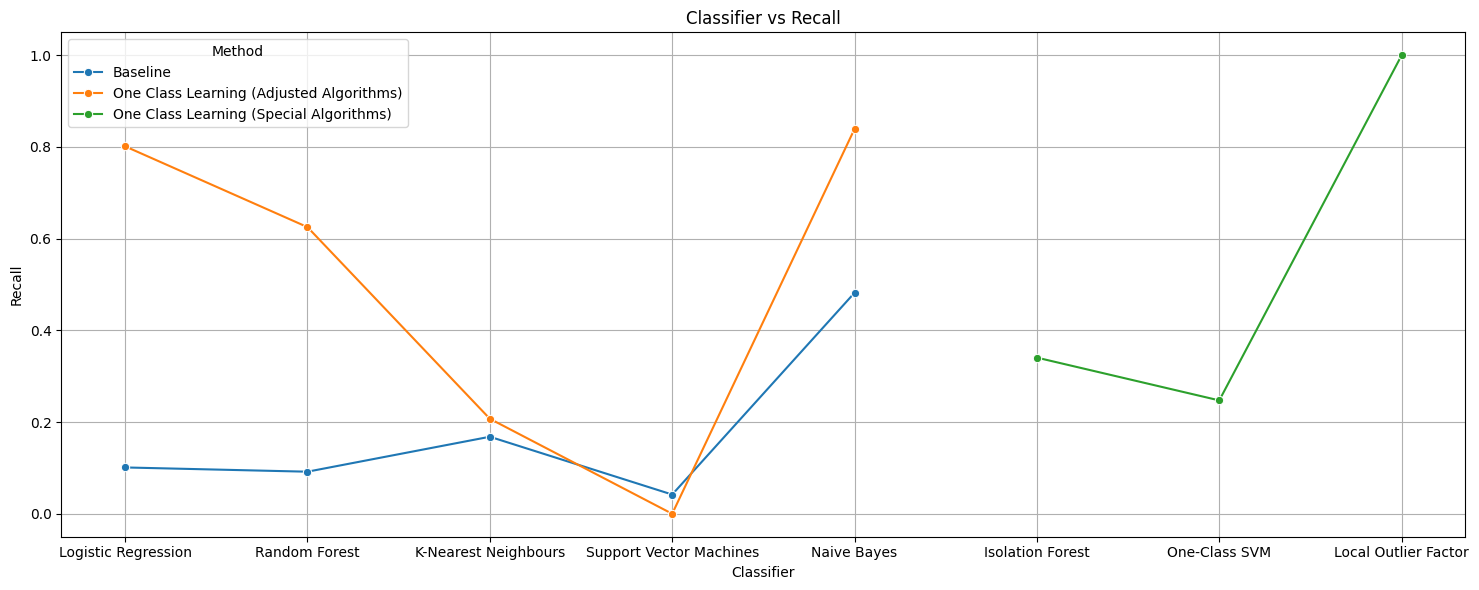

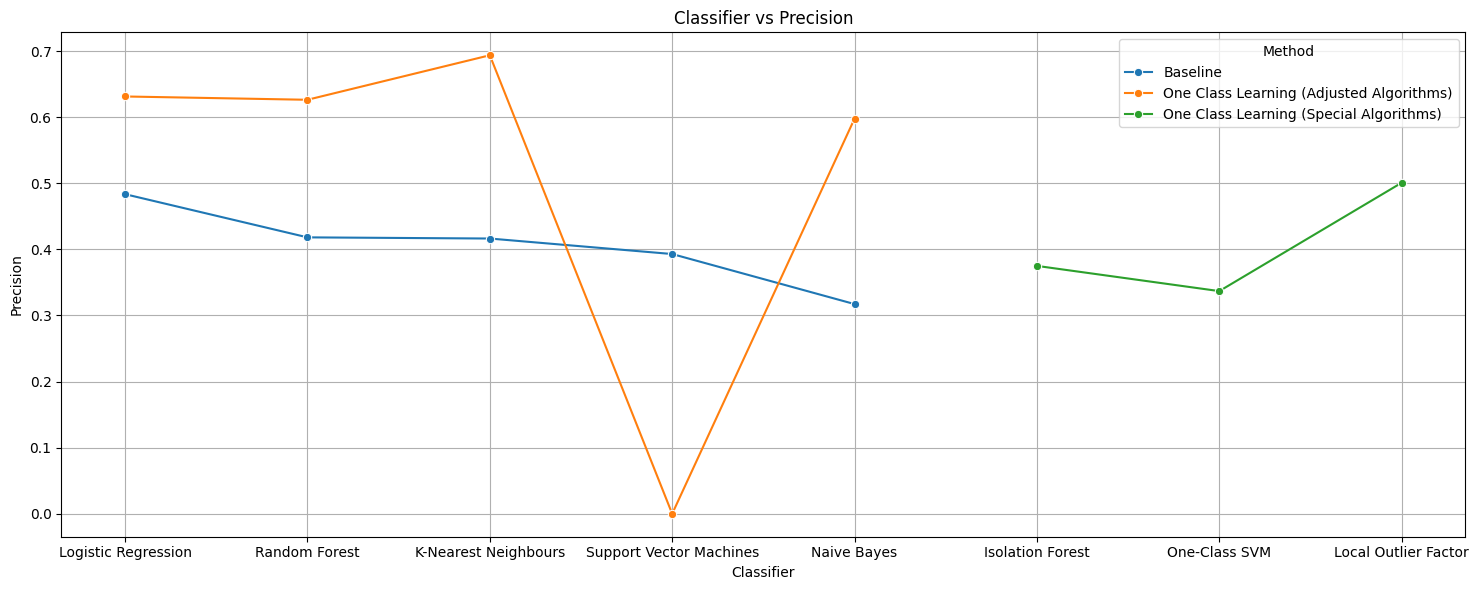

In [19]:
# Concatenate the results
results_df = pd.concat([baseline_results, one_class_learning_adjusted_algos, one_class_learning_special_algos])
# Print results
print(results_df)
results_df.to_csv('Results/StrokeData.OneClassLearning.csv', index=False)
# Plot a Classifier vs Recall Graph -> To evaluate how well the model is performing to detect the fraudulent transactions (minority class)
plot_model_recall_graph(results_df)
# Plot a Classifier vs Precision Graph -> To evaluate how precise the model is to detect the minority class (can be used as a secondary metric for evaluation)
plot_model_precision_graph(results_df)